In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
from toy_plot_helpers import ToyPlot

In [2]:
import openpathsampling.toy_dynamics as toys
plot = ToyPlot()
pes = (
    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, 0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

plot.contour_range = np.arange(-1.5, 1.0, 0.1)

topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

integ = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.toy_engine.ToyEngine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

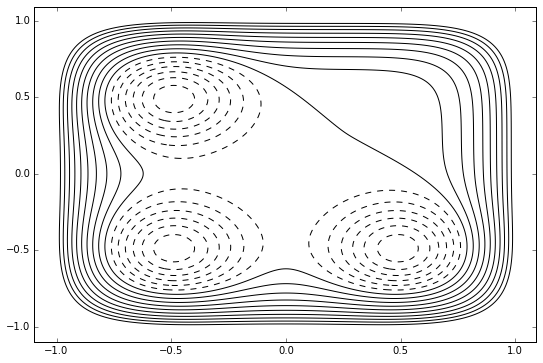

In [3]:
plot.add_pes(pes)
plot.plot()

In [4]:
def xval(snapshot):
    return snapshot.xyz[0][0]

def yval(snapshot):
    return snapshot.xyz[0][1]
    
opX = paths.CV_Function(name="opX", fcn=xval)
opY = paths.CV_Function(name="opY", fcn=yval)

In [5]:
x_under_min = paths.LambdaVolume(opX, float("-inf"), -0.3)
x_over_max = paths.LambdaVolume(opX, 0.3, float("inf")) 
y_under_min = paths.LambdaVolume(opY, float("-inf"), -0.3)
y_over_max = paths.LambdaVolume(opY, 0.3, float("inf")) 

stateA = x_under_min & y_under_min
stateB = x_over_max & y_under_min
stateC = x_under_min & y_over_max

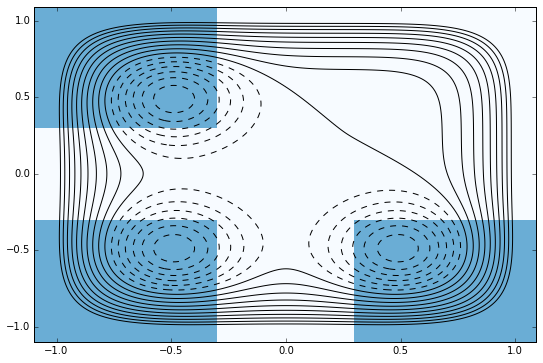

In [6]:
#plot.add_states([stateA, stateB, stateC])
#plot.plot()

In [7]:
interfacesAB = paths.VolumeFactory.LambdaVolumeSet(opX, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesAC = paths.VolumeFactory.LambdaVolumeSet(opY, float("-inf"), [-0.3, -0.2, -0.1, 0.0])

In [8]:
retisAB = paths.RETISTransition(stateA, stateB, interfacesAB, orderparameter=opX, name="A->B")
retisAC = paths.RETISTransition(stateA, stateC, interfacesAC, orderparameter=opY, name="A->C")

In [10]:
mistis = paths.MISTISNetwork([retisAB, retisAC])